# Starfish re-creation of an in-situ sequencing pipeline 

Here, we reproduce the results of a pipeline run on data collected using the gap filling and padlock probe litigation method described in [Ke, Mignardi, et. al, 2013](http://www.nature.com/nmeth/journal/v10/n9/full/nmeth.2563.html). These data represent 5 co-cultured mouse and human cells -- the main idea is to detect a single nucleotide polymorphism (SNP) in the Beta-Actin (ACTB) gene across species. The Python code below correctly re-produces the same results from the original cell profiler - matlab - imagej [pipeline](http://cellprofiler.org/examples/#InSitu) that is publicly accessible. 

In [3]:
import pandas as pd
import numpy as np
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
%matplotlib inline
from showit import image, tile

## Raw Data

The raw data can be downloaded and formatted for analysis by running: ```python examples/get_iss_data.py ><raw data directory> <output directory> --d 1``` from the Starfish directory

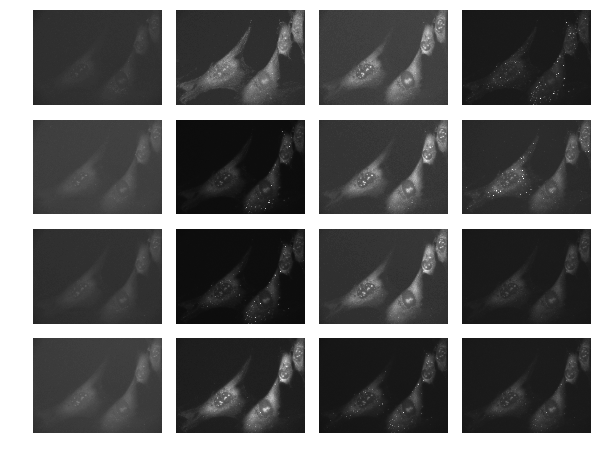

In [4]:
from starfish.io import Stack

# replace <output directory> with where you saved the formatted data to with the above script
in_json = '<output directory>/org.json'

s = Stack()
s.read(in_json)

tile(s.squeeze(),size=10);

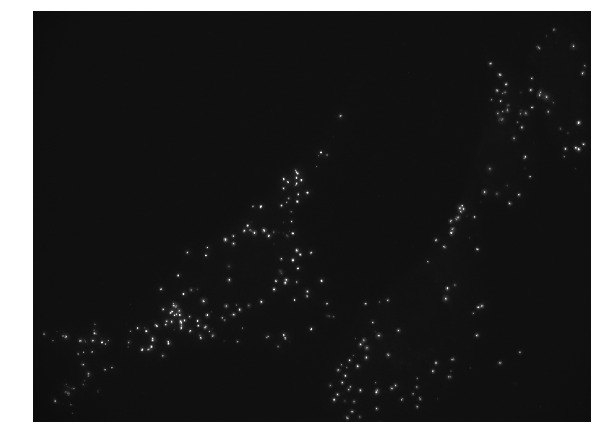

In [6]:
image(s.aux_dict['dots'], size=10)

## Register

For hyb: 0, Shift: [  3.118 -11.021], Error: 0.37367679340203497
For hyb: 1, Shift: [-2.22   2.874], Error: 0.42745295508899667
For hyb: 2, Shift: [ 4.994  0.348], Error: 0.4128292497462391
For hyb: 3, Shift: [ 5.912  0.548], Error: 0.42789421605215633


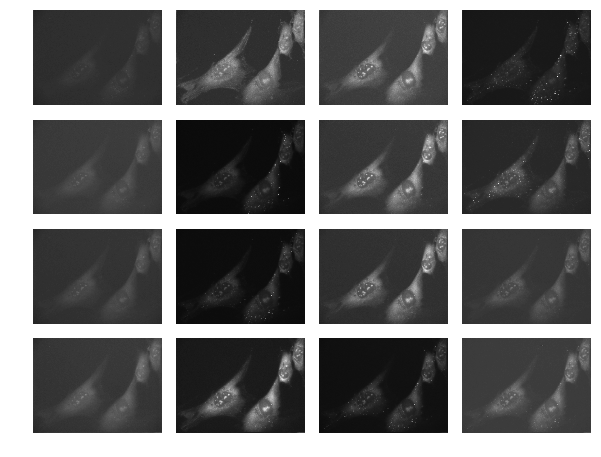

In [7]:
from starfish.pipeline.registration import Registration

registration = Registration.fourier_shift(upsampling=1000)
registration.register(s)

tile(s.squeeze(), size=10);

## Filter

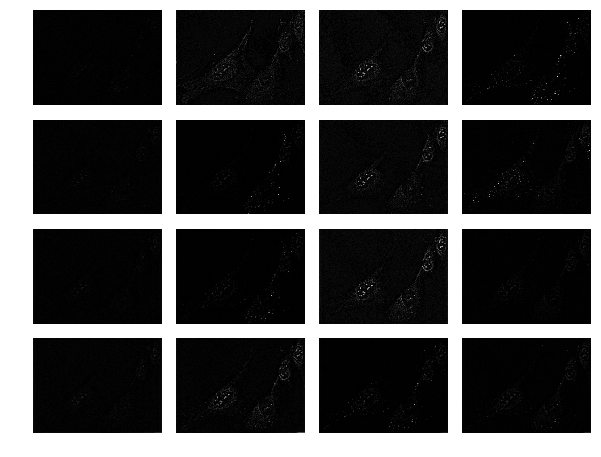

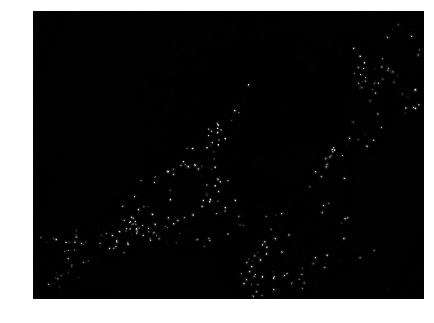

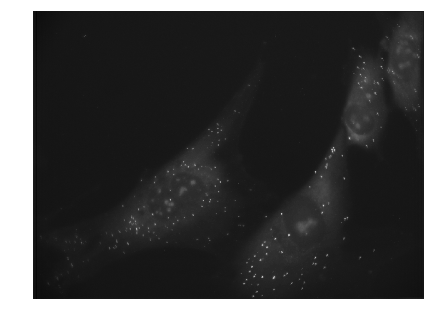

In [8]:
from starfish.filters import white_top_hat

disk_dize = 10

# filter raw images, for all hybs and channels
stack_filt = [white_top_hat(im, disk_dize) for im in s.squeeze()]
stack_filt = s.un_squeeze(stack_filt)

# filter dots
dots_filt = white_top_hat(s.aux_dict['dots'], disk_dize)

# create a 'stain' for segmentation
stain = np.mean(s.max_proj('ch'), axis=0)
stain = stain/stain.max()

# update stack
s.set_stack(stack_filt)
s.set_aux('dots', dots_filt)
s.set_aux('stain', stain)

# visualize
tile(s.squeeze(), bar=False, size=10);
image(s.aux_dict['dots'])
image(s.aux_dict['stain'])

## Detect

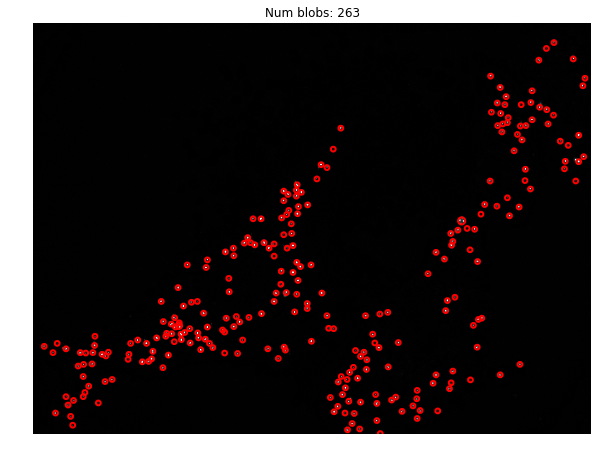

,spot_id,ind,val,ch,hyb
0,0,0,2.762794,0,0
1,1,0,9.361549,0,0
2,2,0,6.798847,0,0
3,3,0,3.302046,0,0
4,4,0,7.276674,0,0


In [9]:
from starfish.spots.gaussian import GaussianSpotDetector

gsp = GaussianSpotDetector(s)
min_sigma = 4
max_sigma = 6
num_sigma=20
thresh=.01
blobs='dots'
measurement_type="max"
bit_map_flag=False

spots_df_tidy = gsp.detect(min_sigma, max_sigma, num_sigma, thresh, blobs, measurement_type, bit_map_flag)
gsp.show(figsize=(10,10))
    
spots_viz = gsp.spots_df_viz
spots_df_tidy.head()

In [10]:
spots_viz.head()

,x,y,r,d,xmin,xmax,ymin,ymax,intensity,spot_id
0,979.0,827.0,5.656854,11.313708,973.0,985.0,821.0,833.0,13,0
1,970.0,749.0,5.656854,11.313708,964.0,976.0,743.0,755.0,155,1
2,968.0,778.0,5.656854,11.313708,962.0,974.0,772.0,784.0,126,2
3,959.0,94.0,5.656854,11.313708,953.0,965.0,88.0,100.0,40,3
4,955.0,760.0,5.656854,11.313708,949.0,961.0,754.0,766.0,174,4


##  Segmentation

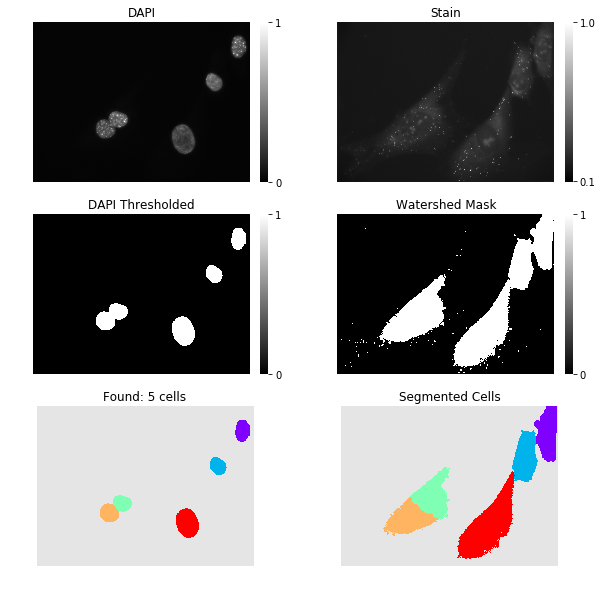

In [11]:
from starfish.watershedsegmenter import WatershedSegmenter

dapi_thresh = .16
stain_thresh = .22
size_lim = (10, 10000)
disk_size_markers = None
disk_size_mask = None
min_dist = 57

seg = WatershedSegmenter(s.aux_dict['dapi'], s.aux_dict['stain'])
cells_labels = seg.segment(dapi_thresh, stain_thresh, size_lim, disk_size_markers, disk_size_mask, min_dist)
seg.show()

## Assignment

In [12]:
from starfish.assign import assign
from starfish.stats import label_to_regions

points = spots_viz.loc[:, ['x', 'y']].values
regions = label_to_regions(cells_labels)
ass = assign(regions, points, use_hull=True)
ass.groupby('cell_id',as_index=False).count().rename(columns={'spot_id':'num spots'})

,cell_id,num spots
0,0,16
1,1,30
2,2,45
3,3,45
4,4,49


In [13]:
ass.head()

,spot_id,cell_id
0,0,None
1,1,None
2,2,None
3,3,None
4,4,None


## Decode

AAGC    160
AGGC     98
GGGG      1
TTTT      1
AAAT      1
AATC      1
AAAC      1
Name: barcode, dtype: int64

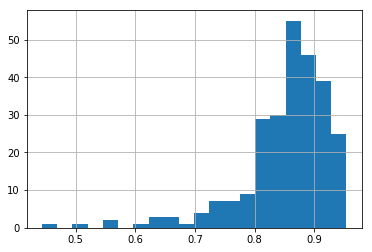

In [14]:
from starfish.decoders.iss import IssDecoder

decoder = IssDecoder(pd.DataFrame({'barcode': ['AAGC', 'AGGC'], 'gene': ['ACTB_human', 'ACTB_mouse']}), 
                     letters=['T', 'G', 'C', 'A'])
dec = decoder.decode(spots_df_tidy)
dec.qual.hist(bins=20)
top_barcode = dec.barcode.value_counts()[0:10]
top_barcode

## Visualization

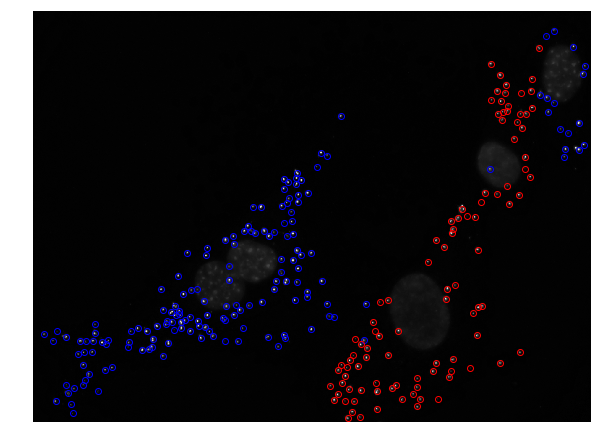

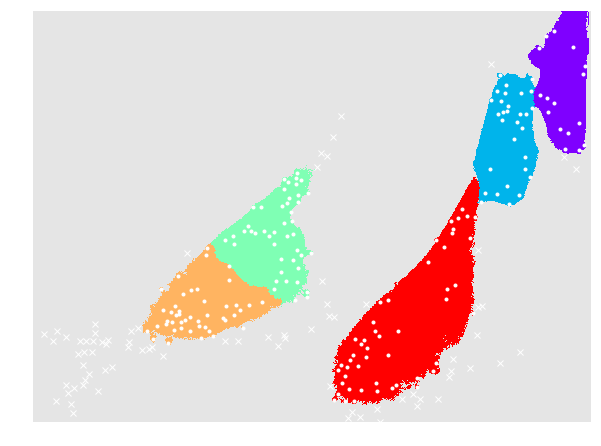

In [15]:
from starfish.stats import label_to_regions

dec_filt = pd.merge(dec, spots_viz, on='spot_id',how='left')
dec_filt = dec_filt[dec_filt.qual>.25]

assert s.aux_dict['dapi'].shape == s.aux_dict['dots'].shape

rgb = np.zeros(s.aux_dict['dapi'].shape + (3,))
rgb[:,:,0] = s.aux_dict['dapi']
rgb[:,:,1] = s.aux_dict['dots']
do = rgb2gray(rgb)
do = do/(do.max())

image(do,size=10)
plt.plot(dec_filt[dec_filt.barcode==top_barcode.index[0]].y, 
         dec_filt[dec_filt.barcode==top_barcode.index[0]].x, 
         'ob', 
         markerfacecolor='None')

plt.plot(dec_filt[dec_filt.barcode==top_barcode.index[1]].y, dec_filt[dec_filt.barcode==top_barcode.index[1]].x, 'or', markerfacecolor='None')

v = pd.merge(spots_viz, ass, on='spot_id')

r = label_to_regions(cells_labels)
im = r.mask(background=[0.9, 0.9, 0.9], dims=s.aux_dict['dots'].shape, stroke=None, cmap='rainbow')
image(im,size=10)

v_ass = v[~v.cell_id.isnull()]
plt.plot(v_ass.y, v_ass.x, '.w')

v_uass = v[v.cell_id.isnull()]
plt.plot(v_uass.y, v_uass.x, 'xw')

## Cell by gene expression table

In [16]:
res = pd.merge(dec, ass, on='spot_id', how='left')
grp = res.groupby(['barcode', 'cell_id'],as_index=False).count()
exp_tab = grp.pivot(index='cell_id', columns='barcode', values = 'spot_id').fillna(0)
exp_tab

barcode,AAGC,AGGC,GGGG,TTTT
cell_id,,,,
0,15.0,1.0,0.0,0.0
1,1.0,29.0,0.0,0.0
2,44.0,0.0,0.0,1.0
3,45.0,0.0,0.0,0.0
4,1.0,47.0,1.0,0.0
